## Часть 3: модель

Используя собранные и распарсенные данные из vk.com будем пытаться предсказать возрастную категорию пользователей: 
до 18 лет, от 18 до 24, от 25 до 34, от 35 до 44. 

In [1]:
import pandas as pd
import numpy as np
import re
import regex

import itertools
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy import sparse
from scipy.sparse import hstack, vstack
from sklearn.metrics import accuracy_score, precision_score, \
classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
from scipy import interp
from itertools import cycle

import pickle
from time import time
from tqdm import tqdm_notebook, tqdm
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_columns', 500)

### Предобработка и очистка данных

In [2]:
with open('raw_data.pkl', 'rb') as f: 
    data = pickle.load(f)
    
# есть несколько дубликатов
data.drop_duplicates('id', inplace=True)
data.index = np.arange(0, len(data))

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29307 entries, 0 to 29306
Data columns (total 41 columns):
first_name              29307 non-null object
id                      29307 non-null int64
last_name               29307 non-null object
age                     29307 non-null int64
about                   29307 non-null object
activities              29307 non-null object
bdate                   23450 non-null object
books                   29307 non-null object
city                    25472 non-null object
country                 27378 non-null object
education_form          3414 non-null object
education_status        2941 non-null object
faculty                 14810 non-null object
faculty_name            14810 non-null object
followers_count         29307 non-null float64
games                   29307 non-null object
graduation              14810 non-null object
has_mobile              29307 non-null float64
has_photo               29307 non-null float64
interests         

Практически по всем возрастам достаточно данных для анализа. Только у 12-ти летних мало данных. 

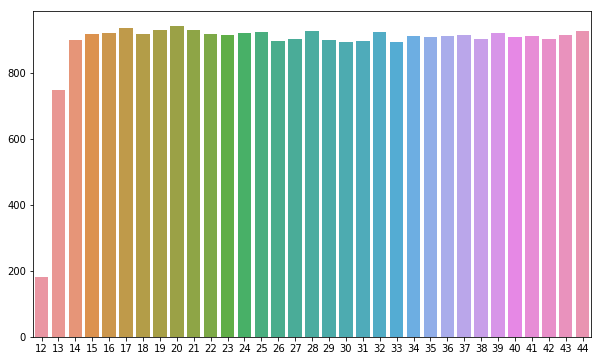

In [4]:
ax, fig = plt.subplots(figsize=(10, 6))
sns.barplot(x=data['age'].value_counts().index, y=data['age'].value_counts().values);

In [5]:
df = pd.DataFrame(data=data['id'].values, columns=['id'])
df.index = np.arange(0, len(data))

#### Таргет

Формирование колонки с целевой переменной для решения задачи мультиклассовой классификации:

In [6]:
def age_group(value):
    if value < 18:
        return 0
    elif 18 <= value <= 24:
        return 1
    elif 25 <= value <= 34:
        return 2
    elif 35 <= value <= 44: 
        return 3
    
    return -1
    
df['age_group'] = data['age'].apply(age_group)

In [7]:
df['age_group'].value_counts()

3    9135
2    9080
1    6481
0    4611
Name: age_group, dtype: int64

Как видим, большого дисбаланса классов нет.

#### Признаки

Здесь обработка многочисленных пропусков, формирование некоторых новых признаков.

In [8]:
df['age'] = data['age']
df['sex'] = data['sex'].astype(int)
#df['country'] = data['country'].apply(lambda x: '-' if x is None else x)
df['has_photo'] = data['has_photo'].astype(int)
df['has_mobile'] = data['has_mobile'].astype(int)
df['status'] = data['status']
df['verified'] = data['verified'].astype(int)
df['followers_count'] = data['followers_count'].astype(int)

# школа: извлечение максимального года выпуска
def school_year_graduated(schools):
    if schools is None or len(schools) == 0:
        return 0
    
    years_graduated = [0]
    for school in schools: 
        if 'year_graduated' in school: 
            years_graduated.append(school['year_graduated'])
    return max(years_graduated)
    
df['school_year_graduated'] = data['schools'].apply(school_year_graduated)

# id высшего уч.заведения; если 0 или None - то вуз не указан
#df['university'] = data['university'].apply(lambda x: -1 if pd.isnull(x) else int(x))

# наличие информации о ВУЗе
df['has_university'] = data['university'].apply(lambda x: 0 if pd.isnull(x) or x==0 else 1)

# год выпуска из вуза; если 0 или None - то либо год не указан, либо вуз
df['graduation'] = data['graduation'].apply(lambda x: -1 if pd.isnull(x) else int(x))

# форма обучения: очное, заочное и т.д.
df['education_form'] = data['education_form'].apply(lambda x: '-' if pd.isnull(x) else x)

# статус: студент, выпускник и т.д.
def get_education_status(value):
    if pd.isnull(value):
        return '-'

    if value == 'Выпускница (специалист)' or value == 'Выпускник (специалист)':
        return 'Выпускник-специалист'
    if value == 'Студентка (специалист)' or value == 'Студент (специалист)':
        return 'Студент-специалист'
    if value == 'Выпускница (магистр)' or value == 'Выпускник (магистр)':
        return 'Выпускник-магистр'
    if value == 'Выпускница (бакалавр)' or value == 'Выпускник (бакалавр)':
        return 'Выпускник-бакалавр'
    if value == 'Студентка (бакалавр)' or value == 'Студент (бакалавр)':
        return 'Студент-бакалавр'
    if value == 'Студентка (магистр)' or value == 'Студент (магистр)':
        return 'Студент-магистр'
    if value == 'Абитуриентка' or value == 'Абитуриент':
        return 'Абитуриент'
    if value == 'Аспирантка' or value == 'Аспирант':
        return 'Аспирант'
    return value
    
df['education_status'] = data['education_status'].apply(get_education_status)

# приблизительный возраст исходя из информации о годах выпуска из школы и университета
def get_age_approximate(value):
    year_school, year_university = value[0], value[1]
    years = []
    if year_school > 0:
        for year in range(17, 20):
            years.append(year + 2018 - year_school)
        
    if year_university > 0: 
        for year in range(21, 27):
            years.append(year + 2018 - year_university)
            
    if len(years) != 0:
        return np.mean(years)
    else:
        return 0
    
df['age_approx'] = df[['school_year_graduated', 'graduation']].apply(get_age_approximate, axis=1)

# cat: семейное положение
df['relation'] = data['relation'].apply(lambda x: -1 if pd.isnull(x) else int(x))

# text
df['interests'] = data['interests']
df['music'] = data['music']
df['activities'] = data['activities']
df['movies'] = data['movies']
df['tv'] = data['tv']
df['books'] = data['books']
df['games'] = data['games']
df['about'] = data['about']
df['quotes'] = data['quotes']

# политические предпочтения
df['personal_political'] = data['personal_political'].apply(lambda x: -1 if x is None else x)
# text: языки
df['personal_langs'] = data['personal_langs'].apply(lambda x: '' if x is None else ' '.join(x))
# text: мировоззрение
df['personal_religion'] = data['personal_religion'].apply(lambda x: '' if x is None else x)
# text: источники вдохновения
df['personal_inspired_by'] = data['personal_inspired_by'].apply(lambda x: '' if x is None else x)
# cat: главное в людях
df['personal_people_main'] = data['personal_people_main'].apply(lambda x: -1 if x is None else int(x))
# cat: главное в жизни
df['personal_life_main'] = data['personal_life_main'].apply(lambda x: -1 if x is None else int(x))
# cat: отношение к курению
df['personal_smoking'] = data['personal_smoking'].apply(lambda x: -1 if x is None else int(x))
# cat: отношение к алкоголю
df['personal_alcohol'] = data['personal_alcohol'].apply(lambda x: -1 if x is None else int(x))

# посты
df['posts'] = data['posts'].apply(lambda x: '' if pd.isna(x) else x)

In [9]:
print(df.shape)
df.head(2)

(29307, 34)


,id,age_group,age,sex,has_photo,has_mobile,status,verified,followers_count,school_year_graduated,has_university,graduation,education_form,education_status,age_approx,relation,interests,music,activities,movies,tv,books,games,about,quotes,personal_political,personal_langs,personal_religion,personal_inspired_by,personal_people_main,personal_life_main,personal_smoking,personal_alcohol,posts
0,290697449,3,44,1,1,1,,1,31071,0,1,0,-,-,0.000000,0,,,,,,,,,,-1,Русский,,,0,0,0,0,Мы наконец сделали это!\nИ за первый день вышл...
1,4364436,3,44,1,1,1,"Это Мир прекрасен уже тем, что каждый год обяз...",1,27106,1990,1,1999,Очное отделение,Выпускник-специалист,43.666667,4,,,,,,,,,,-1,,,,-1,-1,-1,-1,"Афиша. Январь. \n2- ""Будни Любви или у каждого..."


Извлечение из текста постов дополнительной информации: количество символов (предположение: у людей постарше посты длиннее), количество эмоджи (предположение: скорее всего смайлики активно используют подростки и молодые люди), количество тегов и количество слов (далее после "чистки" текста).

In [10]:
%%time
# общее число символов в постах
df['symbols_number'] = df['posts'].apply(lambda text: len(text))

# общее число тэгов в постах
def count_tags(text):
    return len(regex.findall('#', text))

df['tags_number'] = df['posts'].apply(count_tags)

# общее число эмоджи в постах
import emoji

def count_emoji(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return len(emoji_list)

df['emoji_number'] = df['posts'].apply(count_emoji)

CPU times: user 3min 59s, sys: 14.2 s, total: 4min 14s
Wall time: 4min 14s


In [11]:
with open('data.pkl', 'wb') as f: 
    pickle.dump(df, f)

В итоге имеем несколько бинарных признаков, некоторое количество категориальных и численных и признаки, содержащие текстовую информацию:

In [12]:
features_binary = ['sex', 'has_photo', 'has_mobile', 'verified', 'has_university']
features_cat = ['education_form', 'education_status', 'relation', \
                'personal_political', 'personal_people_main', 
                'personal_life_main', 'personal_smoking', 'personal_alcohol']

features_float = ['followers_count', 'age_approx']
features_float += ['symbols_number', 'tags_number', 'emoji_number', 'words_number']

features_text = ['status', 'interests', 'music', 'activities', 'movies', \
                 'tv', 'books', 'games', 'about', 'quotes', 
                 'personal_langs', 'personal_religion', \
                 'personal_inspired_by', 'posts']
target = 'age_group'

#### Обработка текстовых признаков

Чтобы сэкономить время и не делать повторные операции при настройке TfidfVectorizer, я решила обработать текстовые признаки отдельно 3 способами и сохранить полученные данные в разные файлы. 

**Первый вариант**: из текста удаляются все символы, кроме букв, текст разделяется на слова, также удаляются слова, в которых меньше 3 символов. 

**Второй вариант**: дополнительная чистка от стоп-слов.

**Третий вариант**: дополнительная лемматизация слов. 

In [ ]:
from nltk.corpus import stopwords

stop_words_en = stopwords.words('english')
stop_words_ru = stopwords.words('russian')

stop_words = ['www', 'http', 'https', 'ru', 'com', 'su', 'gmail', 'mail', 'yandex', \
              'это', 'этот', 'свой', 'твой', 'мой', 'ваш', 'наш', \
              'самый', 'который']

stop_words_all = set(stop_words_en + stop_words_ru + stop_words)

In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):
    try:
        normal_form = morph.parse(text)[0].normal_form
    except ValueError:
        normal_form = None
    return normal_form

In [ ]:
def extract_words(text, delete_stop_words=False, use_lemmatization=False):
    text = text.lower()
    # оставить буквы и цифры
    text = re.sub(r'[\W]+', ' ', text)
    # удалить цифры
    text = re.sub(r'\d+', '', text)
    # удалить подчёркивания
    text = re.sub(r'[_]+', '', text)
    # удалить два или более пробелов
    text = re.sub(r'[ ]{2,}', ' ', text)
    text = text.strip()
    # разбиение на слова по пробелам
    words = [word for word in text.split()]
    # удаление слов, в которых меньше 3 символов
    words = [word for word in words if len(word) > 2]
    
    if delete_stop_words:
        words = [word for word in words if word not in stop_words_all]
        
    if use_lemmatization: 
        words = [lemmatization(word) for word in words]
        words = list(filter(lambda v: v is not None, words))
        # удаление стоп-слов после лемматизации
        words = [word for word in words if word not in stop_words_all]
        
    return words

In [ ]:
def prepare_text(df, features_text, delete_stop_words=False, use_lemmatization=False):
    for text_feat in features_text:
        df[text_feat] = df[text_feat].\
            apply(lambda text: extract_words(text, delete_stop_words, use_lemmatization))

    # объединение слов обратно в текст
    for text_feat in features_text:
        df[text_feat] = df[text_feat].apply(lambda words: ' '.join(words))
        
    return df

#### 1 вариант

In [ ]:
with open('data.pkl', 'rb') as f: 
    df = pickle.load(f)

In [ ]:
%%time
df = prepare_text(df, features_text, False, False)

In [ ]:
# общее число слов в постах
df['words_number'] = df['posts'].apply(lambda words: len(words))

In [ ]:
with open('data__text_simple.pkl', 'wb') as f: 
    pickle.dump(df, f)

#### 2 вариант: с удалением стоп-слов

In [ ]:
with open('data.pkl', 'rb') as f: 
    df = pickle.load(f)

In [ ]:
%%time
df = prepare_text(df, features_text, True, False)

In [ ]:
# общее число слов в постах
df['words_number'] = df['posts'].apply(lambda words: len(words))

In [ ]:
with open('data__text_stop_words.pkl', 'wb') as f: 
    pickle.dump(df, f)

#### 3 вариант: с лемматизацией

In [ ]:
with open('data.pkl', 'rb') as f: 
    df = pickle.load(f)

In [ ]:
%%time
# обработка около часа
df = prepare_text(df, features_text, True, True)

In [ ]:
# общее число слов в постах
df['words_number'] = df['posts'].apply(lambda words: len(words))

In [ ]:
with open('data__text_lemmatization.pkl', 'wb') as f: 
    pickle.dump(df, f)

Далее методы для формирования итоговой матрицы признаков:

In [3]:
def encoding_binary_features(df, features):
    # get_dummies не кодирует числовые значения
    for column in features:
        if df[column].dtype != 'object':
            df[column] = df[column].apply(lambda x: str(x))
            
    df_bin = pd.get_dummies(df[features], drop_first=True)
    df_bin.columns = features
    return df_bin

# Возвращает DataFrame с категориальными признаками OneHotEncode
def encoding_category_features(df, features, verbose=1):
    if verbose:
        print('Number of category features:', len(features))
    
    # get_dummies не кодирует числовые значения
    for column in features:
        if df[column].dtype != 'object':
            df[column] = df[column].apply(lambda x: str(x))
        
    df_cat = pd.get_dummies(df[features], dummy_na=True)
    
    # удаление пустых колонок, которые могли появиться с пред.операции
    empty_columns = df_cat.loc[:, df_cat.sum(axis=0) == 0].columns
    df_cat.drop(empty_columns, axis=1, inplace=True)
    
    if verbose:
        print('Number of encoded category features:', len(df_cat.columns))
        
    return df_cat

# Некоторые значения признаков есть в тесте, но нет в трейне и наоборот
def intersect_features(train, test, target=None):
    common_feat = list( set(train.keys()) & set(test.keys()))
    
    if target: 
        train_feat = [target] + common_feat
    else:
        train_feat = common_feat
    
    test_feat = common_feat
    
    return train[train_feat], test[test_feat]

In [4]:
# Необходимые преобразования и объединение всех признаков в одну матрицу
def prepare_X(df_train, df_test, features_binary, features_float, features_cat, \
              X_tfidf_train, X_tfidf_test, scaler=None, verbose=1):
    
    # бинарные признаки
    df_train_bin = encoding_binary_features(df_train, features_binary)
    df_test_bin = encoding_binary_features(df_test, features_binary)

    # float или int признаки
    if scaler is not None:
        df_train_float = pd.DataFrame(data=scaler.fit_transform(df_train[features_float].values), 
                                     index=df_train.index, 
                                     columns=features_float)

        df_test_float = pd.DataFrame(data=scaler.transform(df_test[features_float].values), 
                                     index=df_test.index, 
                                     columns=features_float)
    else:
        df_train_float = df_train[features_float]
        df_test_float = df_test[features_float]

    # category признаки
    df_train_cat = encoding_category_features(df_train, features_cat, verbose)
    df_test_cat = encoding_category_features(df_test, features_cat, verbose)
    df_train_cat, df_test_cat = intersect_features(df_train_cat, df_test_cat)

    # объединение binary, float, category признаков в одну матрицу
    df_train_nontext = pd.concat([df_train_bin, df_train_float, df_train_cat], axis=1)
    df_test_nontext = pd.concat([df_test_bin, df_test_float, df_test_cat], axis=1)

    # -> sparse matrix
    X_train_nontext = sparse.csr_matrix(df_train_nontext)
    X_test_nontext = sparse.csr_matrix(df_test_nontext)

    # добавление к полученной матрице текстовых признаков
    X_train = hstack([X_train_nontext, X_tfidf_train])
    X_test = hstack([X_test_nontext, X_tfidf_test])
    
    if verbose:
        print('train, bin:', df_train_bin.shape)
        print('test, bin:', df_test_bin.shape)
        
        print('train, float:', df_train_float.shape)
        print('test, float:', df_test_float.shape)
        
        print('train, cat:', df_train_cat.shape)
        print('test, cat:', df_test_cat.shape)
        
        print('train, non text:', df_train_nontext.shape)
        print('test, non text:', df_test_nontext.shape)

        print('train, text:', X_tfidf_train.shape)
        print('test, text:', X_tfidf_test.shape)
        
        print('full train:', X_train.shape)
        print('full test:', X_test.shape)
    
    return X_train, X_test

In [5]:
def prepare_text_features(df_train, df_valid, features_text, params):
    vectorizers = {}
    X_tfidf_trains = {}
    X_tfidf_valids = {}
    
    for feature_text in tqdm_notebook(features_text, desc='features'):
        vect = TfidfVectorizer()
        
        if feature_text == 'posts':
            vect.set_params(**params['posts'])
        else: 
            vect.set_params(**params['other'])

        # train
        X_tfidf_train = vect.fit_transform(df_train[feature_text])
        X_tfidf_valid = vect.transform(df_valid[feature_text])

        # save to dict
        vectorizers[feature_text] = vect
        X_tfidf_trains[feature_text] = X_tfidf_train
        X_tfidf_valids[feature_text] = X_tfidf_valid
        
    # матрицы Tf-idf
    X_tfidf_train = hstack(list(X_tfidf_trains.values()))
    X_tfidf_valid = hstack(list(X_tfidf_valids.values()))
        
    return X_tfidf_train, X_tfidf_valid

Методы для вывода или отрисовки метрик:

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm/np.sum(cm)
        cm = np.around(cm, decimals=3)
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
def get_accuracy_metric(y_true, y_pred, verbose=1):
    accuracy = accuracy_score(y_true, y_pred)
    if verbose:
        print('Accuracy: {}'.format(accuracy))
    return accuracy
    
def get_classification_report(y_true, y_pred, verbose=1):
    cr = classification_report(y_true, y_pred)
    if verbose:
        print('\nClassification report:\n{}'.format(cr))
    return cr
    
def get_confusion_matrix(y_true, y_pred, normalize=True, verbose=1):
    cm = confusion_matrix(y_true, y_pred)
    
    if verbose:
        plt.figure(figsize=(6, 5))
        plot_confusion_matrix(cm, normalize=normalize,
                          classes=['0', '1', '2', '3'], title='Confusion matrix')
        plt.show()
    return cm

In [8]:
def get_roc_auc(y_true, y_pred, n_classes, verbose=1):
    # Compute ROC curve and ROC area for each class
    y_true_binarize = label_binarize(y_true, classes=np.arange(n_classes))
    y_pred_binarize = label_binarize(y_pred, classes=np.arange(n_classes))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarize[:, i], y_pred_binarize[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarize.ravel(), y_pred_binarize.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    if verbose:
        for i in range(n_classes):
            print('ROC-AUC, class = {}: {}'.format(str(i), np.round(roc_auc[i], decimals=3)))

        print('\nROC-AUC, micro: {}'.format(np.round(roc_auc['micro'], decimals=3)))    
        print('ROC-AUC, macro: {}'.format(np.round(roc_auc['macro'], decimals=3)))
        
    return roc_auc

In [9]:
def get_metrics(model, X, y, verbose=1):
    preds = model.predict(X)
    
    accuracy = get_accuracy_metric(y, preds, verbose)
    #get_classification_report(y, preds, verbose)
    #get_confusion_matrix(y, preds, normalize=True, verbose)
    roc_auc = get_roc_auc(y, preds, n_classes=4, verbose=verbose)
    return accuracy, roc_auc

Основной метрикой качества будет ROC-AUC с микро-усреднением по всем классам, также ради интереса посчитаем и точность. 

Посчитаем 9 различных вариантов с NaiveBayes: данные без удаления стоп-слов и лемматизации, данные с удалением стоп-слов, данные с лемматизацией и униграммы, биграммы, триграммы.  

Результат будет по ходу записываться в таблицу: 

In [10]:
table_results = pd.DataFrame(columns=['model-data', 'ROC-AUC(micro), train', 'ROC-AUC(micro), test', 
                                     'Accuracy, train', 'Accuracy, test'])

### 1. Naive Bayes, без удаления стоп-слов и лемматизации:

In [11]:
with open('../input/data__text_simple.pkl', 'rb') as f: 
    df = pickle.load(f)
    
target = df['age_group']
df = df[features_binary+features_cat+features_float+features_text].copy()

#выбросы
df['age_approx'] = df['age_approx'].apply(lambda x: 0.0 if x < 0 else x)

df_train, df_test, y_train, y_test = train_test_split(df, target, test_size=0.2, 
                                                      shuffle=True, stratify=target.values, random_state=42)

print('train, shape:', df_train.shape)
print('test, shape:', df_test.shape)

print('train:')
print(y_train.value_counts(normalize=True))
print('test:')
print(y_test.value_counts(normalize=True))

train, shape: (23445, 33)
test, shape: (5862, 33)
train:
3    0.311708
2    0.309832
1    0.221113
0    0.157347
Name: age_group, dtype: float64
test:
3    0.311668
2    0.309792
1    0.221256
0    0.157284
Name: age_group, dtype: float64


### 1.1 Naive Bayes, ngram_range=(1,1)

In [13]:
%%time
# Обучение TfidfVectorizer для текстовых признаков
params = {
    'posts': {'ngram_range':(1,1), 'analyzer':'word', 'max_features':10000},
    'other': {'ngram_range':(1,1), 'analyzer':'word', 'max_features':2000}
}

X_tfidf_train, X_tfidf_test = prepare_text_features(df_train, df_test, features_text, params)

X_train, X_test = prepare_X(df_train, df_test, 
                             features_binary, features_float, features_cat, 
                             X_tfidf_train, X_tfidf_test, 
                             scaler=MinMaxScaler(), verbose=0)


CPU times: user 34.8 s, sys: 716 ms, total: 35.5 s
Wall time: 35.5 s


In [14]:
%%time
model = MultinomialNB()
model.fit(X_train, y_train.values)

print('TRAIN:')
train_results = get_metrics(model, X_train, y_train.values)

print('\nTEST:')
test_results = get_metrics(model, X_test, y_test.values)

table_results = table_results.append({'model-data': 'MN, simple data, ngram=(1,1)', 
                                      'ROC-AUC(micro), train':train_results[1]['micro'], 
                                      'ROC-AUC(micro), test':test_results[1]['micro'], 
                                      'Accuracy, train': train_results[0], 
                                      'Accuracy, test': test_results[0]}, ignore_index=True)

TRAIN:
Accuracy: 0.5894220516101514
ROC-AUC, class = 0: 0.75
ROC-AUC, class = 1: 0.707
ROC-AUC, class = 2: 0.709
ROC-AUC, class = 3: 0.742

ROC-AUC, micro: 0.726
ROC-AUC, macro: 0.727

TEST:
Accuracy: 0.4767997270556124
ROC-AUC, class = 0: 0.671
ROC-AUC, class = 1: 0.629
ROC-AUC, class = 2: 0.617
ROC-AUC, class = 3: 0.682

ROC-AUC, micro: 0.651
ROC-AUC, macro: 0.65
CPU times: user 1.28 s, sys: 52 ms, total: 1.34 s
Wall time: 1.33 s


### 1.2 Naive Bayes, ngram_range=(1,2)

In [15]:
%%time
# Обучение TfidfVectorizer для текстовых признаков
params = {
    'posts': {'ngram_range':(1,2), 'analyzer':'word', 'max_features':20000},
    'other': {'ngram_range':(1,1), 'analyzer':'word', 'max_features':2000}
}

X_tfidf_train, X_tfidf_test = prepare_text_features(df_train, df_test, features_text, params)

X_train, X_test = prepare_X(df_train, df_test, 
                             features_binary, features_float, features_cat, 
                             X_tfidf_train, X_tfidf_test, 
                             scaler=MinMaxScaler(), verbose=0)


CPU times: user 2min 29s, sys: 4.91 s, total: 2min 33s
Wall time: 2min 33s


In [16]:
%%time
model = MultinomialNB()
model.fit(X_train, y_train.values)

print('TRAIN:')
train_results = get_metrics(model, X_train, y_train.values)

print('\nTEST:')
test_results = get_metrics(model, X_test, y_test.values)

table_results = table_results.append({'model-data': 'MN, simple data, ngram=(1,2)', 
                                      'ROC-AUC(micro), train':train_results[1]['micro'], 
                                      'ROC-AUC(micro), test':test_results[1]['micro'], 
                                      'Accuracy, train': train_results[0], 
                                      'Accuracy, test': test_results[0]}, ignore_index=True)

TRAIN:
Accuracy: 0.6072510130091704
ROC-AUC, class = 0: 0.729
ROC-AUC, class = 1: 0.738
ROC-AUC, class = 2: 0.719
ROC-AUC, class = 3: 0.75

ROC-AUC, micro: 0.738
ROC-AUC, macro: 0.734

TEST:
Accuracy: 0.48498805868304334
ROC-AUC, class = 0: 0.647
ROC-AUC, class = 1: 0.646
ROC-AUC, class = 2: 0.621
ROC-AUC, class = 3: 0.686

ROC-AUC, micro: 0.657
ROC-AUC, macro: 0.65
CPU times: user 1.72 s, sys: 0 ns, total: 1.72 s
Wall time: 1.71 s


### 1.3 Naive Bayes, ngram_range=(1,3)

In [17]:
%%time
# Обучение TfidfVectorizer для текстовых признаков
params = {
    'posts': {'ngram_range':(1,3), 'analyzer':'word', 'max_features':20000},
    'other': {'ngram_range':(1,1), 'analyzer':'word', 'max_features':2000}
}

X_tfidf_train, X_tfidf_test = prepare_text_features(df_train, df_test, features_text, params)

X_train, X_test = prepare_X(df_train, df_test, 
                             features_binary, features_float, features_cat, 
                             X_tfidf_train, X_tfidf_test, 
                             scaler=MinMaxScaler(), verbose=0)


CPU times: user 5min 42s, sys: 11.9 s, total: 5min 54s
Wall time: 5min 53s


In [18]:
%%time
model = MultinomialNB()
model.fit(X_train, y_train.values)

print('TRAIN:')
train_results = get_metrics(model, X_train, y_train.values)

print('\nTEST:')
test_results = get_metrics(model, X_test, y_test.values)

table_results = table_results.append({'model-data': 'MN, simple data, ngram=(1,3)', 
                                      'ROC-AUC(micro), train':train_results[1]['micro'], 
                                      'ROC-AUC(micro), test':test_results[1]['micro'], 
                                      'Accuracy, train': train_results[0], 
                                      'Accuracy, test': test_results[0]}, ignore_index=True)

TRAIN:
Accuracy: 0.601578161654937
ROC-AUC, class = 0: 0.725
ROC-AUC, class = 1: 0.733
ROC-AUC, class = 2: 0.717
ROC-AUC, class = 3: 0.746

ROC-AUC, micro: 0.734
ROC-AUC, macro: 0.73

TEST:
Accuracy: 0.4805527123848516
ROC-AUC, class = 0: 0.644
ROC-AUC, class = 1: 0.642
ROC-AUC, class = 2: 0.619
ROC-AUC, class = 3: 0.684

ROC-AUC, micro: 0.654
ROC-AUC, macro: 0.647
CPU times: user 1.77 s, sys: 48 ms, total: 1.82 s
Wall time: 1.81 s


In [19]:
table_results

,model-data,"ROC-AUC(micro), train","ROC-AUC(micro), test","Accuracy, train","Accuracy, test"
0,"MN, simple data, ngram=(1,1)",0.726281,0.651200,0.589422,0.476800
1,"MN, simple data, ngram=(1,2)",0.738167,0.656659,0.607251,0.484988
2,"MN, simple data, ngram=(1,3)",0.734385,0.653702,0.601578,0.480553


### 2. Naive Bayes, с удалением стоп-слов:

In [21]:
with open('../input/data__text_stop_words.pkl', 'rb') as f: 
    df = pickle.load(f)
    
target = df['age_group']
df = df[features_binary+features_cat+features_float+features_text]

#выбросы
df['age_approx'] = df['age_approx'].apply(lambda x: 0.0 if x < 0 else x)

df_train, df_test, y_train, y_test = train_test_split(df, target, test_size=0.2, 
                                                      shuffle=True, stratify=target.values, random_state=42)

print('train, shape:', df_train.shape)
print('test, shape:', df_test.shape)

print('train:')
print(y_train.value_counts(normalize=True))
print('test:')
print(y_test.value_counts(normalize=True))

train, shape: (23445, 33)
test, shape: (5862, 33)
train:
3    0.311708
2    0.309832
1    0.221113
0    0.157347
Name: age_group, dtype: float64
test:
3    0.311668
2    0.309792
1    0.221256
0    0.157284
Name: age_group, dtype: float64


### 2.1 Naive Bayes, ngram_range=(1,1)

In [23]:
%%time
# Обучение TfidfVectorizer для текстовых признаков
params = {
    'posts': {'ngram_range':(1,1), 'analyzer':'word', 'max_features':10000},
    'other': {'ngram_range':(1,1), 'analyzer':'word', 'max_features':2000}
}

X_tfidf_train, X_tfidf_test = prepare_text_features(df_train, df_test, features_text, params)

X_train, X_test = prepare_X(df_train, df_test, 
                             features_binary, features_float, features_cat, 
                             X_tfidf_train, X_tfidf_test, 
                             scaler=MinMaxScaler(), verbose=0)


CPU times: user 31.7 s, sys: 176 ms, total: 31.9 s
Wall time: 31.9 s


In [24]:
%%time
model = MultinomialNB()
model.fit(X_train, y_train.values)

print('TRAIN:')
train_results = get_metrics(model, X_train, y_train.values)

print('\nTEST:')
test_results = get_metrics(model, X_test, y_test.values)

table_results = table_results.append({'model-data': 'MN, stop-words, ngram=(1,1)', 
                                      'ROC-AUC(micro), train':train_results[1]['micro'], 
                                      'ROC-AUC(micro), test':test_results[1]['micro'], 
                                      'Accuracy, train': train_results[0], 
                                      'Accuracy, test': test_results[0]}, ignore_index=True)

TRAIN:
Accuracy: 0.6037534655576882
ROC-AUC, class = 0: 0.761
ROC-AUC, class = 1: 0.726
ROC-AUC, class = 2: 0.715
ROC-AUC, class = 3: 0.748

ROC-AUC, micro: 0.736
ROC-AUC, macro: 0.737

TEST:
Accuracy: 0.48004094165813715
ROC-AUC, class = 0: 0.678
ROC-AUC, class = 1: 0.631
ROC-AUC, class = 2: 0.616
ROC-AUC, class = 3: 0.686

ROC-AUC, micro: 0.653
ROC-AUC, macro: 0.653
CPU times: user 1.12 s, sys: 4 ms, total: 1.12 s
Wall time: 1.12 s


### 2.2 Naive Bayes, ngram_range=(1,2)

In [25]:
%%time
# Обучение TfidfVectorizer для текстовых признаков
params = {
    'posts': {'ngram_range':(1,2), 'analyzer':'word', 'max_features':20000},
    'other': {'ngram_range':(1,1), 'analyzer':'word', 'max_features':2000}
}

X_tfidf_train, X_tfidf_test = prepare_text_features(df_train, df_test, features_text, params)

X_train, X_test = prepare_X(df_train, df_test, 
                             features_binary, features_float, features_cat, 
                             X_tfidf_train, X_tfidf_test, 
                             scaler=MinMaxScaler(), verbose=0)


CPU times: user 2min 27s, sys: 3.5 s, total: 2min 30s
Wall time: 2min 30s


In [26]:
%%time
model = MultinomialNB()
model.fit(X_train, y_train.values)

print('TRAIN:')
train_results = get_metrics(model, X_train, y_train.values)

print('\nTEST:')
test_results = get_metrics(model, X_test, y_test.values)

table_results = table_results.append({'model-data': 'MN, stop-words, ngram=(1,2)', 
                                      'ROC-AUC(micro), train':train_results[1]['micro'], 
                                      'ROC-AUC(micro), test':test_results[1]['micro'], 
                                      'Accuracy, train': train_results[0], 
                                      'Accuracy, test': test_results[0]}, ignore_index=True)

TRAIN:
Accuracy: 0.617359778204308
ROC-AUC, class = 0: 0.725
ROC-AUC, class = 1: 0.75
ROC-AUC, class = 2: 0.73
ROC-AUC, class = 3: 0.757

ROC-AUC, micro: 0.745
ROC-AUC, macro: 0.74

TEST:
Accuracy: 0.48430569771409077
ROC-AUC, class = 0: 0.639
ROC-AUC, class = 1: 0.645
ROC-AUC, class = 2: 0.621
ROC-AUC, class = 3: 0.692

ROC-AUC, micro: 0.656
ROC-AUC, macro: 0.649
CPU times: user 1.41 s, sys: 4 ms, total: 1.41 s
Wall time: 1.41 s


### 2.3 Naive Bayes, ngram_range=(1,3)

In [27]:
%%time
# Обучение TfidfVectorizer для текстовых признаков
params = {
    'posts': {'ngram_range':(1,3), 'analyzer':'word', 'max_features':20000},
    'other': {'ngram_range':(1,1), 'analyzer':'word', 'max_features':2000}
}

X_tfidf_train, X_tfidf_test = prepare_text_features(df_train, df_test, features_text, params)

X_train, X_test = prepare_X(df_train, df_test, 
                             features_binary, features_float, features_cat, 
                             X_tfidf_train, X_tfidf_test, 
                             scaler=MinMaxScaler(), verbose=0)


CPU times: user 5min 9s, sys: 9.07 s, total: 5min 18s
Wall time: 5min 17s


In [28]:
%%time
model = MultinomialNB()
model.fit(X_train, y_train.values)

print('TRAIN:')
train_results = get_metrics(model, X_train, y_train.values)

print('\nTEST:')
test_results = get_metrics(model, X_test, y_test.values)

table_results = table_results.append({'model-data': 'MN, stop-words, ngram=(1,3)', 
                                      'ROC-AUC(micro), train':train_results[1]['micro'], 
                                      'ROC-AUC(micro), test':test_results[1]['micro'], 
                                      'Accuracy, train': train_results[0], 
                                      'Accuracy, test': test_results[0]}, ignore_index=True)

TRAIN:
Accuracy: 0.6132224354873107
ROC-AUC, class = 0: 0.721
ROC-AUC, class = 1: 0.745
ROC-AUC, class = 2: 0.728
ROC-AUC, class = 3: 0.754

ROC-AUC, micro: 0.742
ROC-AUC, macro: 0.737

TEST:
Accuracy: 0.48225861480723303
ROC-AUC, class = 0: 0.636
ROC-AUC, class = 1: 0.645
ROC-AUC, class = 2: 0.621
ROC-AUC, class = 3: 0.688

ROC-AUC, micro: 0.655
ROC-AUC, macro: 0.647
CPU times: user 1.43 s, sys: 8 ms, total: 1.44 s
Wall time: 1.43 s


In [29]:
table_results

,model-data,"ROC-AUC(micro), train","ROC-AUC(micro), test","Accuracy, train","Accuracy, test"
0,"MN, simple data, ngram=(1,1)",0.726281,0.651200,0.589422,0.476800
1,"MN, simple data, ngram=(1,2)",0.738167,0.656659,0.607251,0.484988
2,"MN, simple data, ngram=(1,3)",0.734385,0.653702,0.601578,0.480553
3,"MN, stop-words, ngram=(1,1)",0.735836,0.653361,0.603753,0.480041
4,"MN, stop-words, ngram=(1,2)",0.744907,0.656204,0.617360,0.484306
5,"MN, stop-words, ngram=(1,3)",0.742148,0.654839,0.613222,0.482259


### 3. Naive Bayes, с удалением стоп-слов и лемматизацией:

In [31]:
with open('../input/data__text_lemmatization.pkl', 'rb') as f: 
    df = pickle.load(f)
    
target = df['age_group']
df = df[features_binary+features_cat+features_float+features_text]

#выбросы
df['age_approx'] = df['age_approx'].apply(lambda x: 0.0 if x < 0 else x)

df_train, df_test, y_train, y_test = train_test_split(df, target, test_size=0.2, 
                                                      shuffle=True, stratify=target.values, random_state=42)

print('train, shape:', df_train.shape)
print('test, shape:', df_test.shape)

print('train:')
print(y_train.value_counts(normalize=True))
print('test:')
print(y_test.value_counts(normalize=True))

train, shape: (23445, 33)
test, shape: (5862, 33)
train:
3    0.311708
2    0.309832
1    0.221113
0    0.157347
Name: age_group, dtype: float64
test:
3    0.311668
2    0.309792
1    0.221256
0    0.157284
Name: age_group, dtype: float64


### 3.1 Naive Bayes, ngram_range=(1,1)

In [33]:
%%time
# Обучение TfidfVectorizer для текстовых признаков
params = {
    'posts': {'ngram_range':(1,1), 'analyzer':'word', 'max_features':10000},
    'other': {'ngram_range':(1,1), 'analyzer':'word', 'max_features':2000}
}

X_tfidf_train, X_tfidf_test = prepare_text_features(df_train, df_test, features_text, params)

X_train, X_test = prepare_X(df_train, df_test, 
                             features_binary, features_float, features_cat, 
                             X_tfidf_train, X_tfidf_test, 
                             scaler=MinMaxScaler(), verbose=0)


CPU times: user 24.9 s, sys: 168 ms, total: 25 s
Wall time: 25 s


In [34]:
%%time
model = MultinomialNB()
model.fit(X_train, y_train.values)

print('TRAIN:')
train_results = get_metrics(model, X_train, y_train.values)

print('\nTEST:')
test_results = get_metrics(model, X_test, y_test.values)

table_results = table_results.append({'model-data': 'MN, lemmatization, ngram=(1,1)', 
                                      'ROC-AUC(micro), train':train_results[1]['micro'], 
                                      'ROC-AUC(micro), test':test_results[1]['micro'], 
                                      'Accuracy, train': train_results[0], 
                                      'Accuracy, test': test_results[0]}, ignore_index=True)

TRAIN:
Accuracy: 0.5989336745574749
ROC-AUC, class = 0: 0.757
ROC-AUC, class = 1: 0.719
ROC-AUC, class = 2: 0.711
ROC-AUC, class = 3: 0.747

ROC-AUC, micro: 0.733
ROC-AUC, macro: 0.733

TEST:
Accuracy: 0.48430569771409077
ROC-AUC, class = 0: 0.677
ROC-AUC, class = 1: 0.63
ROC-AUC, class = 2: 0.62
ROC-AUC, class = 3: 0.692

ROC-AUC, micro: 0.656
ROC-AUC, macro: 0.655
CPU times: user 1.19 s, sys: 0 ns, total: 1.19 s
Wall time: 1.18 s


### 3.2 Naive Bayes, ngram_range=(1,2)

In [35]:
%%time
# Обучение TfidfVectorizer для текстовых признаков
params = {
    'posts': {'ngram_range':(1,2), 'analyzer':'word', 'max_features':20000},
    'other': {'ngram_range':(1,1), 'analyzer':'word', 'max_features':2000}
}

X_tfidf_train, X_tfidf_test = prepare_text_features(df_train, df_test, features_text, params)

X_train, X_test = prepare_X(df_train, df_test, 
                             features_binary, features_float, features_cat, 
                             X_tfidf_train, X_tfidf_test, 
                             scaler=MinMaxScaler(), verbose=0)


CPU times: user 2min 2s, sys: 3.31 s, total: 2min 6s
Wall time: 2min 5s


In [36]:
%%time
model = MultinomialNB()
model.fit(X_train, y_train.values)

print('TRAIN:')
train_results = get_metrics(model, X_train, y_train.values)

print('\nTEST:')
test_results = get_metrics(model, X_test, y_test.values)

table_results = table_results.append({'model-data': 'MN, lemmatization, ngram=(1,2)', 
                                      'ROC-AUC(micro), train':train_results[1]['micro'], 
                                      'ROC-AUC(micro), test':test_results[1]['micro'], 
                                      'Accuracy, train': train_results[0], 
                                      'Accuracy, test': test_results[0]}, ignore_index=True)

TRAIN:
Accuracy: 0.6107485604606526
ROC-AUC, class = 0: 0.72
ROC-AUC, class = 1: 0.741
ROC-AUC, class = 2: 0.722
ROC-AUC, class = 3: 0.755

ROC-AUC, micro: 0.74
ROC-AUC, macro: 0.735

TEST:
Accuracy: 0.48618219037871035
ROC-AUC, class = 0: 0.639
ROC-AUC, class = 1: 0.65
ROC-AUC, class = 2: 0.617
ROC-AUC, class = 3: 0.693

ROC-AUC, micro: 0.657
ROC-AUC, macro: 0.65
CPU times: user 1.43 s, sys: 0 ns, total: 1.43 s
Wall time: 1.43 s


### 3.3 Naive Bayes, ngram_range=(1,3)

In [37]:
%%time
# Обучение TfidfVectorizer для текстовых признаков
params = {
    'posts': {'ngram_range':(1,3), 'analyzer':'word', 'max_features':20000},
    'other': {'ngram_range':(1,1), 'analyzer':'word', 'max_features':2000}
}

X_tfidf_train, X_tfidf_test = prepare_text_features(df_train, df_test, features_text, params)

X_train, X_test = prepare_X(df_train, df_test, 
                             features_binary, features_float, features_cat, 
                             X_tfidf_train, X_tfidf_test, 
                             scaler=MinMaxScaler(), verbose=0)


CPU times: user 4min 18s, sys: 7.67 s, total: 4min 26s
Wall time: 4min 25s


In [38]:
%%time
model = MultinomialNB()
model.fit(X_train, y_train.values)

print('TRAIN:')
train_results = get_metrics(model, X_train, y_train.values)

print('\nTEST:')
test_results = get_metrics(model, X_test, y_test.values)

table_results = table_results.append({'model-data': 'MN, lemmatization, ngram=(1,3)', 
                                      'ROC-AUC(micro), train':train_results[1]['micro'], 
                                      'ROC-AUC(micro), test':test_results[1]['micro'], 
                                      'Accuracy, train': train_results[0], 
                                      'Accuracy, test': test_results[0]}, ignore_index=True)

TRAIN:
Accuracy: 0.6075922371507784
ROC-AUC, class = 0: 0.717
ROC-AUC, class = 1: 0.738
ROC-AUC, class = 2: 0.721
ROC-AUC, class = 3: 0.752

ROC-AUC, micro: 0.738
ROC-AUC, macro: 0.732

TEST:
Accuracy: 0.48430569771409077
ROC-AUC, class = 0: 0.638
ROC-AUC, class = 1: 0.65
ROC-AUC, class = 2: 0.616
ROC-AUC, class = 3: 0.689

ROC-AUC, micro: 0.656
ROC-AUC, macro: 0.648
CPU times: user 1.43 s, sys: 0 ns, total: 1.43 s
Wall time: 1.43 s


Как видно из таблицы, лучшие результаты получились при построении биграмм с удалением стоп-слов и лемматизацией. В целом, разница для тестовой выборки в roc-auc заметна только в третьем знаке. Точность около 0.5. Это лучше случайного гадания из 4-х классов примерно в 2 раза. 

In [41]:
table_results.sort_values(by='ROC-AUC(micro), test', ascending=False)

,model-data,"ROC-AUC(micro), train","ROC-AUC(micro), test","Accuracy, train","Accuracy, test"
7,"MN, lemmatization, ngram=(1,2)",0.740499,0.657455,0.610749,0.486182
1,"MN, simple data, ngram=(1,2)",0.738167,0.656659,0.607251,0.484988
4,"MN, stop-words, ngram=(1,2)",0.744907,0.656204,0.617360,0.484306
6,"MN, lemmatization, ngram=(1,1)",0.732622,0.656204,0.598934,0.484306
8,"MN, lemmatization, ngram=(1,3)",0.738395,0.656204,0.607592,0.484306
5,"MN, stop-words, ngram=(1,3)",0.742148,0.654839,0.613222,0.482259
2,"MN, simple data, ngram=(1,3)",0.734385,0.653702,0.601578,0.480553
3,"MN, stop-words, ngram=(1,1)",0.735836,0.653361,0.603753,0.480041
0,"MN, simple data, ngram=(1,1)",0.726281,0.651200,0.589422,0.476800


Попробуем улучшить результаты модели подбором параметра alpha: 

### Naive Bayes, лучшая модель: 

In [57]:
params = {
    'posts': {'ngram_range':(1,2), 'analyzer':'word', 'max_features':20000},
    'other': {'ngram_range':(1,1), 'analyzer':'word', 'max_features':2000}
}

X_tfidf_train, X_tfidf_test = prepare_text_features(df_train, df_test, features_text, params)

X_train, X_test = prepare_X(df_train, df_test, 
                             features_binary, features_float, features_cat, 
                             X_tfidf_train, X_tfidf_test, 
                             scaler=MinMaxScaler(), verbose=0)

#### Подбор параметра alpha:

In [58]:
alphas = list(np.arange(0.1, 1.6, step=0.1))+[2, 3]

train_metrics = []
test_metrics = []

for alpha in alphas:
    print('Parameter, alpha =', alpha)

    model = MultinomialNB(alpha=alpha)
    model.fit(X_train, y_train.values)
    
    print('TRAIN:')
    train_metrics.append(get_metrics(model, X_train, y_train.values))
    print('TEST:')
    test_metrics.append(get_metrics(model, X_test, y_test.values))
    print('-'*100)

Parameter, alpha = 0.1
TRAIN:
Accuracy: 0.6128812113457027
ROC-AUC, class = 0: 0.835
ROC-AUC, class = 1: 0.724
ROC-AUC, class = 2: 0.722
ROC-AUC, class = 3: 0.755

ROC-AUC, micro: 0.742
ROC-AUC, macro: 0.759
TEST:
Accuracy: 0.4643466393722279
ROC-AUC, class = 0: 0.727
ROC-AUC, class = 1: 0.605
ROC-AUC, class = 2: 0.611
ROC-AUC, class = 3: 0.684

ROC-AUC, micro: 0.643
ROC-AUC, macro: 0.657
----------------------------------------------------------------------------------------------------
Parameter, alpha = 0.2
TRAIN:
Accuracy: 0.6086159095756025
ROC-AUC, class = 0: 0.828
ROC-AUC, class = 1: 0.724
ROC-AUC, class = 2: 0.718
ROC-AUC, class = 3: 0.751

ROC-AUC, micro: 0.739
ROC-AUC, macro: 0.755
TEST:
Accuracy: 0.46673490276356194
ROC-AUC, class = 0: 0.727
ROC-AUC, class = 1: 0.609
ROC-AUC, class = 2: 0.611
ROC-AUC, class = 3: 0.685

ROC-AUC, micro: 0.644
ROC-AUC, macro: 0.658
----------------------------------------------------------------------------------------------------
Parameter, al

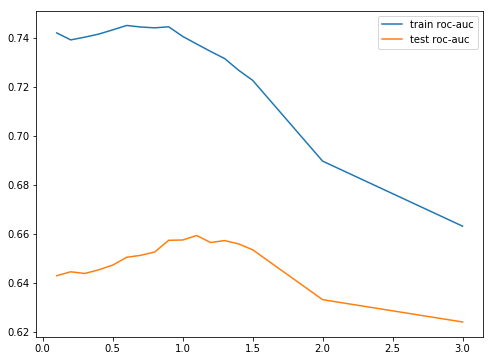

In [44]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(alphas, [tm[1]['micro'] for tm in train_metrics], label='train roc-auc')
plt.plot(alphas, [tm[1]['micro'] for tm in test_metrics], label='test roc-auc')
plt.legend()
plt.show()

In [66]:
train_roc_auc = np.array([tm[1]['micro'] for tm in train_metrics])
test_roc_auc = np.array([tm[1]['micro'] for tm in test_metrics])

alpha = alphas[test_roc_auc.argmax()]

model = MultinomialNB(alpha=alphas[test_roc_auc.argmax()])
model.fit(X_train, y_train)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
    
print('Best results with MultinomialNB, alpha = ', alpha)
print('roc-auc(micro), train:', get_roc_auc(y_train, train_preds, n_classes=4, verbose=0)['micro'])
print('roc-auc(micro), test:', get_roc_auc(y_test, test_preds, n_classes=4, verbose=0)['micro'])
print('accuracy, train:',  accuracy_score(y_train, train_preds))
print('accuracy, test:',  accuracy_score(y_test, test_preds))

Best results with MultinomialNB, alpha =  1.1
roc-auc(micro), train: 0.7373995876874956
roc-auc(micro), test: 0.6592744228363472
accuracy, train: 0.6060993815312433
accuracy, test: 0.48891163425452067


Итак, с наивным байесом мы получили значение roc-auc равным 0.659, точность 0.49.

Посмотрим на матрицу ошибок: видно, что модель больше всего путает соседние по возрасту классы.

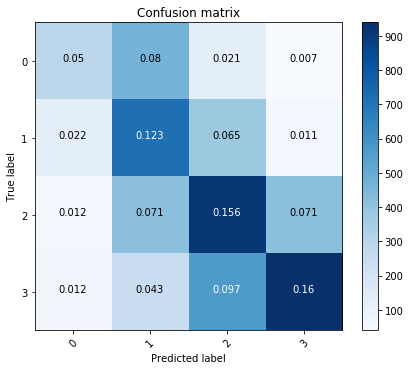

array([[292, 467, 122,  41],
       [129, 721, 381,  66],
       [ 68, 415, 914, 419],
       [ 70, 250, 568, 939]])

In [69]:
get_confusion_matrix(y_test, test_preds, normalize=True)

Также я решила попробовать для этой задачи регрессию. Возьмем данные, на которых наивный байес показал себя лучше всего и сравним две модели. 

### Logistic Regression, ngram_range=(1,2)

In [70]:
%%time
model = LogisticRegression(C=1.0, random_state=42, solver='liblinear', multi_class='ovr')
model.fit(X_train, y_train.values)

CPU times: user 42.3 s, sys: 0 ns, total: 42.3 s
Wall time: 42.3 s


In [71]:
print('TRAIN:')
train_results = get_metrics(model, X_train, y_train.values)

print('\nTEST:')
test_results = get_metrics(model, X_test, y_test.values)

TRAIN:
Accuracy: 0.7746214544679036
ROC-AUC, class = 0: 0.839
ROC-AUC, class = 1: 0.821
ROC-AUC, class = 2: 0.839
ROC-AUC, class = 3: 0.88

ROC-AUC, micro: 0.85
ROC-AUC, macro: 0.845

TEST:
Accuracy: 0.5211531900375298
ROC-AUC, class = 0: 0.704
ROC-AUC, class = 1: 0.645
ROC-AUC, class = 2: 0.627
ROC-AUC, class = 3: 0.724

ROC-AUC, micro: 0.681
ROC-AUC, macro: 0.675


### Подбор коэффициента регуляризации:

In [72]:
%%time
Cs = [0.1, 0.5, 1, 2, 3]
# np.arange(1, 3.1, step=0.1)

train_metrics = []
test_metrics = []

for C in Cs:
    print('Parameter, C =', C)

    model = LogisticRegression(C=C, random_state=42, solver='liblinear', multi_class='ovr')
    model.fit(X_train, y_train.values)
    
    print('TRAIN:')
    train_metrics.append(get_metrics(model, X_train, y_train.values))
    print('TEST:')
    test_metrics.append(get_metrics(model, X_test, y_test.values))
    print('-'*100)

Parameter, C = 0.1
TRAIN:
Accuracy: 0.5926636809554277
ROC-AUC, class = 0: 0.709
ROC-AUC, class = 1: 0.662
ROC-AUC, class = 2: 0.695
ROC-AUC, class = 3: 0.782

ROC-AUC, micro: 0.728
ROC-AUC, macro: 0.712
TEST:
Accuracy: 0.49744114636642783
ROC-AUC, class = 0: 0.667
ROC-AUC, class = 1: 0.609
ROC-AUC, class = 2: 0.608
ROC-AUC, class = 3: 0.717

ROC-AUC, micro: 0.665
ROC-AUC, macro: 0.65
----------------------------------------------------------------------------------------------------
Parameter, C = 0.5
TRAIN:
Accuracy: 0.7185327361910855
ROC-AUC, class = 0: 0.794
ROC-AUC, class = 1: 0.771
ROC-AUC, class = 2: 0.796
ROC-AUC, class = 3: 0.85

ROC-AUC, micro: 0.812
ROC-AUC, macro: 0.803
TEST:
Accuracy: 0.5226885022176732
ROC-AUC, class = 0: 0.693
ROC-AUC, class = 1: 0.647
ROC-AUC, class = 2: 0.627
ROC-AUC, class = 3: 0.724

ROC-AUC, micro: 0.682
ROC-AUC, macro: 0.673
----------------------------------------------------------------------------------------------------
Parameter, C = 1
TRAIN:

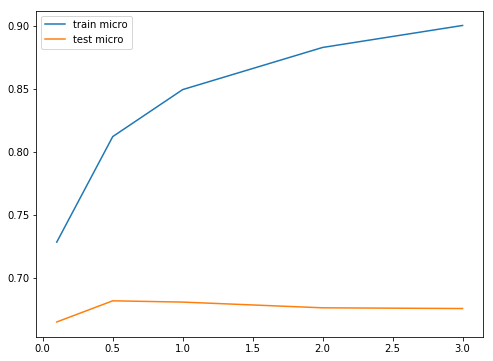

In [74]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(Cs, [tm[1]['micro'] for tm in train_metrics], label='train micro')
plt.plot(Cs, [tm[1]['micro'] for tm in test_metrics], label='test micro')
plt.legend()
plt.show()

Уточние коэффициента: 

In [80]:
%%time
Cs = np.arange(0.5, 1.05, step=0.05)

train_metrics = []
test_metrics = []

for C in Cs:
    print('Parameter, C =', C)
    model = LogisticRegression(C=C, random_state=42, solver='liblinear', multi_class='ovr')
    model.fit(X_train, y_train.values)
    
    print('TRAIN:')
    train_metrics.append(get_metrics(model, X_train, y_train.values))
    print('TEST:')
    test_metrics.append(get_metrics(model, X_test, y_test.values))
    print('-'*100)

Parameter, C = 0.5
TRAIN:
Accuracy: 0.7185327361910855
ROC-AUC, class = 0: 0.794
ROC-AUC, class = 1: 0.771
ROC-AUC, class = 2: 0.796
ROC-AUC, class = 3: 0.85

ROC-AUC, micro: 0.812
ROC-AUC, macro: 0.803
TEST:
Accuracy: 0.5226885022176732
ROC-AUC, class = 0: 0.693
ROC-AUC, class = 1: 0.647
ROC-AUC, class = 2: 0.627
ROC-AUC, class = 3: 0.724

ROC-AUC, micro: 0.682
ROC-AUC, macro: 0.673
----------------------------------------------------------------------------------------------------
Parameter, C = 0.55
TRAIN:
Accuracy: 0.727105992748987
ROC-AUC, class = 0: 0.799
ROC-AUC, class = 1: 0.784
ROC-AUC, class = 2: 0.805
ROC-AUC, class = 3: 0.854

ROC-AUC, micro: 0.818
ROC-AUC, macro: 0.81
TEST:
Accuracy: 0.5209825997952917
ROC-AUC, class = 0: 0.694
ROC-AUC, class = 1: 0.647
ROC-AUC, class = 2: 0.629
ROC-AUC, class = 3: 0.724

ROC-AUC, micro: 0.681
ROC-AUC, macro: 0.673
----------------------------------------------------------------------------------------------------
Parameter, C = 0.6000000

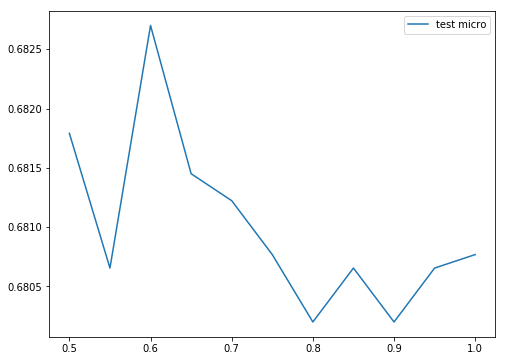

In [81]:
fig, ax = plt.subplots(figsize=(8, 6))
#plt.plot(Cs, [tm[1]['micro'] for tm in train_metrics], label='train micro')
plt.plot(Cs, [tm[1]['micro'] for tm in test_metrics], label='test micro')
plt.legend()
plt.show()

In [82]:
train_roc_auc = np.array([tm[1]['micro'] for tm in train_metrics])
test_roc_auc = np.array([tm[1]['micro'] for tm in test_metrics])

C = Cs[test_roc_auc.argmax()]

model = LogisticRegression(C=C, random_state=42, solver='liblinear', multi_class='ovr')
model.fit(X_train, y_train)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
    
print('Best results with LogisticRegression, C = ', C)
print('roc-auc(micro), train:', get_roc_auc(y_train, train_preds, n_classes=4, verbose=0)['micro'])
print('roc-auc(micro), test:', get_roc_auc(y_test, test_preds, n_classes=4, verbose=0)['micro'])
print('accuracy, train:',  accuracy_score(y_train, train_preds))
print('accuracy, test:',  accuracy_score(y_test, test_preds))

Best results with LogisticRegression, C =  0.6000000000000001
roc-auc(micro), train: 0.8225634463638303
roc-auc(micro), test: 0.6827021494370522
accuracy, train: 0.7338451695457454
accuracy, test: 0.5240532241555783


С регрессией результаты чуть поинтереснее: roc-auc 0.683, точность 0.524. Также явно третий класс выделяется моделью лучше.

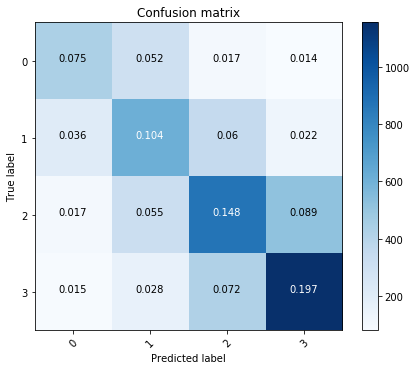

array([[ 437,  302,  102,   81],
       [ 209,  610,  350,  128],
       [ 101,  324,  870,  521],
       [  87,  162,  423, 1155]])

In [83]:
get_confusion_matrix(y_test, test_preds, normalize=True)

В целом, определять возраст только по тексту затруднительно. У нас были признаки, например, учитывающие год окончания вуза или школы, но эти поля редко заполняются пользователями, кроме того нет гарантии, что пользователь пишет достоверную информацию о себе. Также не очень понятно, как vk.com определяет возраст и соответственно непонятно какого качества данные мы получаем при запросе по API. Для дальнейшего улучшения алгоритма, я бы попробовала собрать еще данных. Особенно для пользователей старше 25 лет, на них модель ошибалась больше всего. Другим вариантом улучшения я вижу собирать информацию о друзьях пользователя. Наверняка, там в подавляющем большинстве будут ровесники. Кроме того следует как-то научиться выделять аккаунты-магазины, аккаунты, предлагающие различные услуги и т.д. Также возможно какое-нибудь улучшение было бы при выделении слов из тегов #ЛюбителейПисатьВесьТекстБезПробелов :) 